An example PyTorch end-to-end workflow

 ## What is being covered
 **Preparation and loading of data
 
 **model building
 
 **model fitting (training)
 
 **model predictions and evaluations
 
 **saving and loading a model
 
 **putting it all together

In [1]:
import torch
from torch import nn #nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

torch.__version__

'2.0.0'

In [2]:
## Data Prep and loading
#ML is a game of two parts, getting data into numerical representation, and building model to learn patterns in that representation
#Let's create some known data using the linear regression formula

In [3]:
#Creating known parameters
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim = 1)
y = weight*X +bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [4]:
#Splitting data into test and train sets
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test, = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [5]:
#Data visualization
def plot_predictions(train_data = X_train,
                     train_labels = y_train,
                     test_data = X_test,
                     test_labels = y_test,
                     predictions = None):
    '''plots training and test data, and compares predictions
    '''
    plt.figure(figsize =(10,7))
    
    #plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label = "training data")
    
    #plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label = "testing data")
    
    
    #If there are predictions, compare them
    if predictions is not None:
        plt.scatter(test_data, predictions, c="r", label="Predictions")
    
    #Show the legend
    plt.legend(prop={'size': 14})

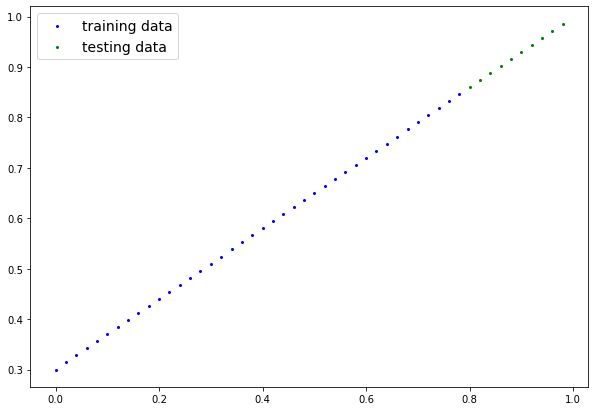

In [6]:
 plot_predictions()

In [7]:
# 2. build PyTorch model

In [8]:
#Create linear regression model class
#model starts with random values for weight and bias
#looks at training data and adjust the random values to better represent the data
#through two main algos
    #gradient descent
    #back propogation

class LinearRegressionModel(nn.Module): #<- almost everything from PyTorch inherits from nn.Module
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1,
                                               requires_grad = True,
                                               dtype = torch.float))
        self.bias = nn.Parameter(torch.randn(1,
                                           requires_grad = True, #<- allows PyTorch to track the gradients of this specific paramter for gradient descent
                                           dtype = torch.float))
        #Forward method to define the computation in the model
        
    def forward(self, x: torch.Tensor) -> torch.Tensor: #<- any subclass of nn.Module needs to override forward()
        return self.weights * x + self.bias #linear regression formula
    #x is the input data
    

    

The model:
Starts with random values
*looks at training data to see if it can adjust the random values to fit the data
**through two main algos, gradient descent, back propogation

##PyTorch model building essentials
**torch.nn contains all of the buildings for computational graphs

**torch.autograd() is used to track the gradients of the parameters

**torch.nn.Parameter - what parameters whould our model try and learn, often a PyTorch layer from torch.nn will set these for us

**torch.nn.Module - The base class for all neural network modules. If you sublcass it, you should write forward()

**torch.optim()- this is where the optimizers in PyTorch live, and they will help with the gradient descent

**def forward() = all nn.Module subclasses are required to overwrite forward(). This method defines what happens in the forward computation

In [9]:
 ###checking the contents of the built model
    
#.parameters() shows the details of the model

torch.manual_seed(42)

#create an instance of the linear regression model

model_0 = LinearRegressionModel()
list(model_0.parameters())
#model_0.weights.dtype


[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [10]:
#List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [11]:
weight, bias

(0.7, 0.3)

In [12]:
###making prediction using 'torch.inference_mode()'

#To check our model's predictive power, lets see how well it predicts ytest based on xtest

#When we pass data through the model, it goes and runs through the forward() method

In [13]:
X_test, y_test
    

(tensor([[0.8000],
         [0.8200],
         [0.8400],
         [0.8600],
         [0.8800],
         [0.9000],
         [0.9200],
         [0.9400],
         [0.9600],
         [0.9800]]),
 tensor([[0.8600],
         [0.8740],
         [0.8880],
         [0.9020],
         [0.9160],
         [0.9300],
         [0.9440],
         [0.9580],
         [0.9720],
         [0.9860]]))

In [14]:
with torch.inference_mode():   #inference mode removes the gradient tracking, to avoid updating model while testing
    y_preds = model_0(X_test)
y_preds

#this can save time since there is no longer tracking of all tensors

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

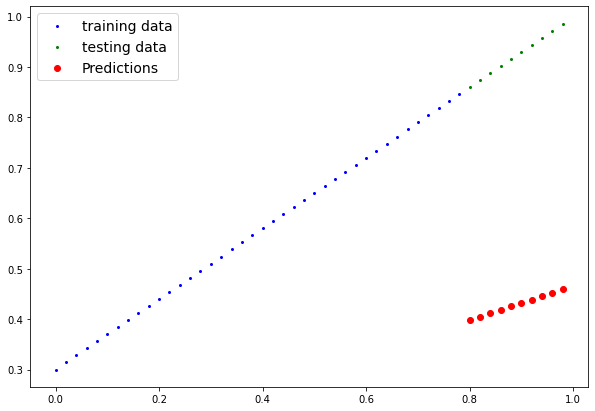

In [15]:
#As you can see, the prediction was pretty bad. Let's visualize them
plot_predictions(predictions=y_preds)

# Training a model
Purpose is to make the model's random parameter such that they fit the data 

**Make the parameters a better representation of the dataset

**One way to measure how poor or how wrong the model is predicting, is to use a loss function/criterions/cost function

**Loss function: **A function to measure how wrong aa model's predictions are to the ideal output. Lower is better

**We Also need an Optimizer: Takes into account the loss of a model and adjust the model's parameters (eg: weight and bias) (To improve loss function)

**In PyTorch, we need:
*Training Loop
*Testing Loop

In [16]:
model_0.state_dict( )

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [17]:
#L1Loss is used for Mean Absolute Error for a loss function

loss_fn = nn.L1Loss()

#Setting up an optimizer
#Using SGD, a stochastic gradient descent, random gradient descent
optimizer = torch.optim.SGD(params =model_0.parameters(),
                           lr=0.01) #lr = learning rate, a very important hyperparamters

Q: Which loss function and optimizer should I use?

A: This will be problem specific. With experience, you'll get and idea of what works and what doesn't with your particular problem set

For a regression problem like ours, a loss function of nn.L1Loss()
and an optimizer like torch.optim.SGF() will suffice.

For a classification problem, you'll like wnat to use a loss function of nn.BCELoss() (Binary cross entropy loss)

##building a training loop and testing loop

A couple of things we need in a training loop:
0. loop through the data
1. forward pass (this involves data moving through the models 'forward()' functions to make proedictions on data - also called forward propogation
2. Calculate the loss (compare forward pass predictions to ground truth labels
3. Optimizer zero grad
4. Loss backward- move backwards through the network to calculate the gradients of each of the parameters of our model with respect to the loss (**back propogation**)
5. Optimizer step- use the optimizer to adjust our model's parameters to try and improve the loss (**Gradient descent**)

**Gradient is a slope, model aims to have a gradient of zero, meaning loss will be zero (Or as minimal as possible)


In [18]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [19]:
#an epoch is one loop through the data... (This is a hyperparameter because we've set it ourself)
torch.manual_seed(42)

epochs = 200

#Track different values
epoch_count = []

loss_values = []

test_loss_values = []


###Training
#0 Loop through the data
for epoch in range(epochs):
    #Set the model to training mode
    model_0.train() #Train mode in PyTroch sets all paramters that require gradients to require gradients
    
    #1. Forward Pass
    y_pred = model_0(X_train)
    
    #2. Calculate the Loss
    loss = loss_fn(y_pred, y_train)
    
    #print(f"Loss: {loss}")
    
    #3. Optimizer zero grad
    
    optimizer.zero_grad()

    
    #4. Perform backpropogation on the loss with respect to the paramters of the model
    loss.backward()
    
    #5. Step the optimizer (Perform gradient descent)
    optimizer.step() #by default how the optimizer changes will accumulate through the loop so... we have to zero them above in step 3 for the next iteration of the loop
    
    model_0.eval() #Turns off gradient tracking
    
    
    ##Testing
    model_0.eval() #turns off different settings in the model not needed for evaluation/testing (dropout/batch norm layers)
    with torch.inference_mode(): #turns of gradeint tracking & a couple more things behind the scenes
        #1. do the forward pass
        test_pred = model_0(X_test)
        
        #2. calculate the loss
        test_loss = loss_fn(test_pred, y_test)
    
    #Print out what's happening
    if epoch % 10 == 0:
        epoch_count.append(epoch)
        loss_values.append(loss)
        test_loss_values.append(test_loss)
        #print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")
    #Print out model state_dict()
        #print(model_0.state_dict())
                   


In [20]:
epoch_count, loss_values, test_loss_values

([0,
  10,
  20,
  30,
  40,
  50,
  60,
  70,
  80,
  90,
  100,
  110,
  120,
  130,
  140,
  150,
  160,
  170,
  180,
  190],
 [tensor(0.3129, grad_fn=<MeanBackward0>),
  tensor(0.1977, grad_fn=<MeanBackward0>),
  tensor(0.0891, grad_fn=<MeanBackward0>),
  tensor(0.0531, grad_fn=<MeanBackward0>),
  tensor(0.0454, grad_fn=<MeanBackward0>),
  tensor(0.0417, grad_fn=<MeanBackward0>),
  tensor(0.0382, grad_fn=<MeanBackward0>),
  tensor(0.0348, grad_fn=<MeanBackward0>),
  tensor(0.0313, grad_fn=<MeanBackward0>),
  tensor(0.0279, grad_fn=<MeanBackward0>),
  tensor(0.0245, grad_fn=<MeanBackward0>),
  tensor(0.0210, grad_fn=<MeanBackward0>),
  tensor(0.0176, grad_fn=<MeanBackward0>),
  tensor(0.0142, grad_fn=<MeanBackward0>),
  tensor(0.0107, grad_fn=<MeanBackward0>),
  tensor(0.0073, grad_fn=<MeanBackward0>),
  tensor(0.0039, grad_fn=<MeanBackward0>),
  tensor(0.0089, grad_fn=<MeanBackward0>),
  tensor(0.0089, grad_fn=<MeanBackward0>),
  tensor(0.0089, grad_fn=<MeanBackward0>)],
 [tensor(

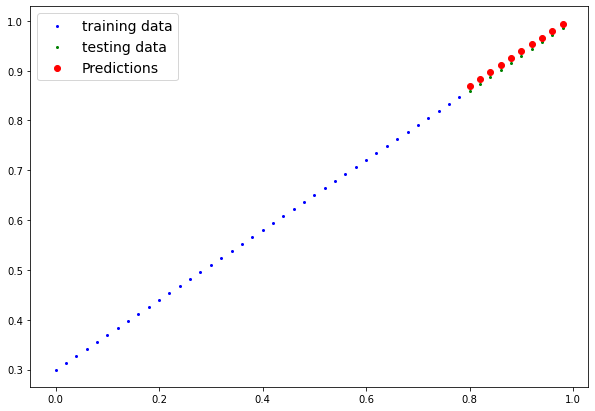

In [21]:
with torch.inference_mode():
    y_preds_new = model_0(X_test)
plot_predictions(predictions = y_preds_new)

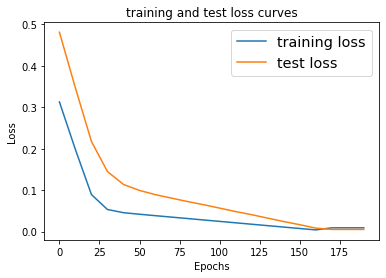

In [22]:
import numpy as np
#plot the loss curves
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()))
plt.plot(epoch_count, test_loss_values)
plt.title("training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(["training loss","test loss"], fontsize = "x-large")

Saving a model in PyTorch

Three main methods for saving and loading models

*1. 'torch.save()' - allows you to save a PyTorch object in Python's pickle format

*2. `torch.load()` allows you to load a saved PyTorch object


*3. `torch.nn.Modeule.load_state_dict()` allows you to load a model's saved state dictionary

In [23]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [24]:
from pathlib import Path

#Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents = True, exist_ok = True)

#2. create model save path
MODEL_NAME = "Basic_Regression_Model_Pytorch.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
torch.save(obj = model_0.state_dict(),
                 f=MODEL_SAVE_PATH)
#MODEL_SAVE_PATH
#3. save model state_dict
print(f"Saving model to: {MODEL_SAVE_PATH}")

Saving model to: models/Basic_Regression_Model_Pytorch.pth


In [25]:
#If I want to save to current directory rather than a new one, then I do this

#import os
#MODEL_NAME = "Basic_Regression_Model_Pytorch.pth"
#MODEL_CURR = Path(os.getcwd())
#MODEL_CURR_SAVE = MODEL_CURR / MODEL_NAME
#torch.save(obj = model_0.state_dict(),
                 #f=MODEL_CURR_SAVE)
#print(f"Saving model to: {MODEL_SAVE_PATH}")

In [26]:
ls -l models

total 8
-rw-r--r--  1 yashpatel  staff  1219 Apr 15 18:36 Basic_Regression_Model_Pytorch.pth


### loading a PyTorch model
Since we saved our model's `state_dict()` rather than the entire model, we'll cerate a new instance of ourmodel class and load the saved `state_dict()` into that

In [27]:
#To load in a saved state_dict, instantiate a new instance of our model class
loaded_model_0 = LinearRegressionModel()

#Load the saved state_dict of model_0
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [28]:
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [29]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [30]:
#Make predictions with loaded model
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test)
loaded_model_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [36]:
#Make some model preds
model_0.eval()
with torch.inference_mode():
    model_preds=model_0(X_test)
model_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

### Putting it all together
Seeing it all in one place

In [38]:
# import torch
from torch import nn
import matplotlib.pyplot as plt

#check pytorch version
torch.__version__

'2.0.0'

In [43]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

Using device: mps


In [45]:
#Creating data using linear regression formula y = weight*features + bias
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.02

X = torch.arange(start,end,step).unsqueeze(dim = 1)
y=weight* X + bias
X[:10], y[:10]


(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [ ]:
#Split the data
train_split = int(0.8 * len(x))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:],y[train_split:]
